In [11]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')

In [12]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# 10.000 zufällige negative Stichproben ziehen
not_depressed_sample = not_depressed.sample(n=10062, random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])

x = balanced_dataset.loc[:, 'Age':'Stress_Level']
y = balanced_dataset['Depression']

In [13]:
import torch

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)  # set random seed for reproducibility

# Spaltennamen nach Typ trennen
categorical_cols = x.select_dtypes(include=['category']).columns.tolist()
numeric_cols = x.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("numeric", RobustScaler(), numeric_cols), # StandardScaler() um Data Leakage zu vermeiden?
    ("categorical", OneHotEncoder(drop='first'), categorical_cols)
])

x_processed = preprocessor.fit_transform(x)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_processed, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

batch_size = 16
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train.values)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val.values)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test.values)), batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 755
Validation batches: 252
Test batches: 252


/\ Allgemeiner Code

\\/ Spezieller Code für das Ensemble Learning

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FunnelNetwork(nn.Module):
    """
    Funnel architecture: Wide → Narrow
    Starts with many neurons and gradually reduces.
    Good for learning broad features then focusing.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 128 → 64 → 32 (funnel shape)
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
class InvertedFunnelNetwork(nn.Module):
    """
    Inverted Funnel architecture: Narrow → Wide
    Starts focused and gradually expands representation.
    Builds increasingly complex features.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
class BrickNetwork(nn.Module):
    """
    Brick architecture: Constant width
    All hidden layers have the same number of neurons.
    Good for maintaining consistent representation.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 64 → 64 → 64 (brick/constant shape)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [17]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    return train_loss / len(train_loader.dataset), correct / total


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            eval_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    return eval_loss / len(data_loader.dataset), correct / total


def train_model(model, train_loader, val_loader, num_epochs=150, lr=0.01):
    """Train a single model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    best_val_acc = 0.0
    patience = 20
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_acc

In [ ]:
features, labels = next(iter(train_loader))
print(features.shape)

input_dim = features.shape[1]
output_dim = len(set(labels.numpy()))

torch.Size([16, 19])


In [ ]:
models = {
    "Funnel": FunnelNetwork(input_dim=input_dim, output_dim=output_dim),
    "Inverted Funnel": InvertedFunnelNetwork(input_dim=input_dim, output_dim=output_dim),
    "Brick": BrickNetwork(input_dim=input_dim, output_dim=output_dim)
}

for name, model in models.items():
    best_val_acc = train_model(model, train_loader, val_loader)
    print(f"{name} Best Validation Accuracy: {best_val_acc:.4f}")

Funnel Best Validation Accuracy: 0.6845
Inverted Funnel Best Validation Accuracy: 0.6820
Brick Best Validation Accuracy: 0.6842


In [22]:
import numpy as np

def predict_majority_voting(models, X):
    """
    Hard majority voting: Each model votes for a class, majority wins.
    """
    votes = []
    
    # Collect votes from each model
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            votes.append(predicted.numpy())
    
    # votes shape: (n_models, n_samples)
    votes = np.array(votes)
    
    # Majority voting for each sample
    ensemble_predictions = []
    for i in range(votes.shape[1]):
        # Get votes for this sample from all models
        sample_votes = votes[:, i]
        # Find most common prediction (mode)
        prediction = np.bincount(sample_votes).argmax()
        ensemble_predictions.append(prediction)
    
    return np.array(ensemble_predictions)

              precision    recall  f1-score   support

       False       0.67      0.72      0.69      2013
        True       0.70      0.64      0.67      2012

    accuracy                           0.68      4025
   macro avg       0.68      0.68      0.68      4025
weighted avg       0.68      0.68      0.68      4025



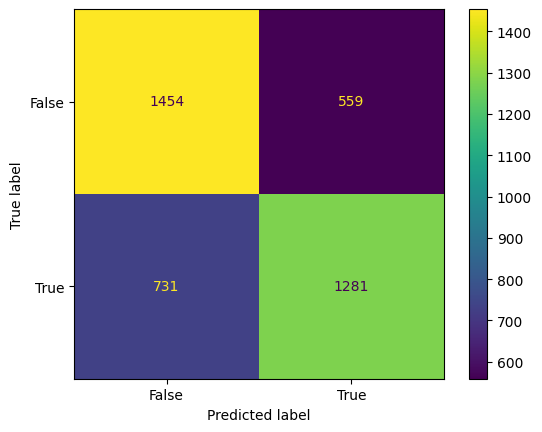

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = predict_majority_voting(models.values(), torch.FloatTensor(x_test))

print(classification_report(y_test, y_pred, target_names=sorted(y_test.unique().astype(str))))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=sorted(y_test.unique().astype(str)))